<a href="https://colab.research.google.com/github/serg-kas/NN-archive/blob/main/%D0%90%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_2020_Light_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_25_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Light задание

**Сегментация стройки**

1. Сделайте выделение классов по отдельности
 
  a. Пола

  b. Того, что за окном

  c. Людей

  d. Батарей

  e. Лампочек
  
  f. Все остальное - фон

2. Сделайте свою собственную архитектуру и запустите, оцените точность на проверочной выборке

3. Проверьте различные batch_size

4. Проверьте различные активационные функции

5. Напишите ваши выводы
 

### Импорт библиотек


In [ ]:
import numpy as np # Импортируем библиотеку numpy

from tensorflow.keras.models import Model        # Импортируем модели keras: Model
# Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras import backend as K        # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam     # Импортируем оптимизатор Adam
from tensorflow.keras import utils               # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from sklearn.model_selection import train_test_split

import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
from google.colab import files                   # Импортируем Модуль files для работы с файлами

import matplotlib.pyplot as plt                  # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from PIL import Image # импортируем модель Image для работы с изображениями
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


### Загрузка картинок

In [ ]:
# Глобальные параметры
img_width = 176         # Ширина уменьшенной картинки 
img_height = 240        # Высота уменьшенной картинки 

num_classes = 6         # ПЕРЕДЕЛЫВАЕМ С 7 на 6 КЛАССОВ

directory = '/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки/'  # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка'                                         # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка'                                             # Название папки с файлами проверочной выборки

### Оригинальные изображения

In [ ]:
train_images = []        # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = []          # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()   # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')):  # Проходим по всем файлам в каталоге по указанному пути     
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height)))   # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      

print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_images))    # Отображаем количество элементов в обучающей выборке

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')): # Проходим по всем файлам в каталоге по указанному пути                  
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   

print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_images))     # Отображаем количество элементов в проверочной выборке

Обучающая выборка загружена. Время загрузки: 198.79c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 11.29c
Количество изображений:  50


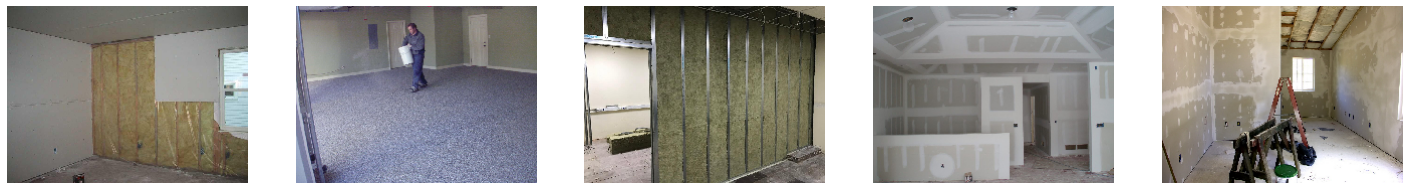

In [ ]:
# Посмотрим n оригинальных случайных картинок из тренировочной выборки

n = 5 
fig, axs = plt.subplots(1, n, figsize=(25, 10))   # Создаем полотно из n графиков

for i in range(n):                                # Выводим в цикле n случайных изображений
  img = random.choice(train_images)               # Выбираем случайное фото для отображения
  axs[i].axis('off')
  axs[i].imshow(img)               # Отображаем фото

plt.show()                         # Показываем изображения

### Сегментированные изображения

In [ ]:
train_segments = []       # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = []         # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()    # Засекаем текущее время
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): # Проходим по всем файлам в каталоге по указанному пути     
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height)))    # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size                                                      

print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок обучающей выборки
print ('Количество изображений: ', len(train_segments)) # Отображаем количество элементов в обучающем наборе сегментированных изображений

cur_time = time.time() # Засекаем текущее время
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):   # Проходим по всем файлам в каталоге по указанному пути                                                     
    val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))      # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size   

print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='') # Отображаем время загрузки картинок проверочной выборки
print ('Количество изображений: ', len(val_segments)) # Отображаем количество элементов в проверочном наборе сегментированных изображений

Обучающая выборка загружена. Время загрузки: 231.1c
Количество изображений:  900
Проверочная выборка загружена. Время загрузки: 12.01c
Количество изображений:  50


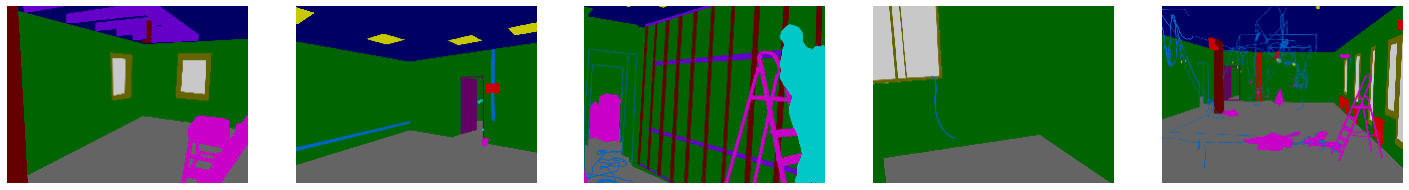

In [ ]:
# Посмотрим n случайных сегментированных картинок из тренировочной выборки

n = 5 # Количество выводимых случайных картинок
fig, axs = plt.subplots(1, n, figsize=(25, 10))     # Создаем полотно из n графиков

for i in range(n):                                  # Выводим в цикле n случайных изображений
  img = random.choice(train_segments)               # Выбираем случайное фото для отображения
  axs[i].axis('off')
  axs[i].imshow(img)      # Отображаем фото

plt.show()                #Показываем изображения

### Создание выборки


In [ ]:
# Функция преобразования пикселя сегментированного изображения в индекс

'''
ВЫДЕЛЯЕМ КЛАССЫ ПО ЗАДАНИЮ

0 - Пол
1 - То, что за окном
2 - Люди
3 - Батареи
4 - Лампочки
5 - Все остальное - фон
 
'''

def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=0        # пол
  elif (49>=color[0]>=0)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=5         # потолок
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=5         # стена
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=5         # колонна
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=5       # проем
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=5       # дверь
  elif (149>=color[0]>=51)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=5       # окно
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=1  # внешний мир
  elif (49>=color[0]>=0)and(49>=color[1]>=51)and(249>=color[2]>=151) : index=5       # лестница
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=5        # перила
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=3        # батарея
  elif (49>=color[0]>=0)and(249>=color[1]>=151)and(249>=color[2]>=151) : index=2     # люди
  elif (249>=color[0]>=151)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=5     # инвентарь
  elif (249>=color[0]>=151)and(249>=color[1]>=151)and(49>=color[2]>=0) : index=4     # источники света
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(249>=color[2]>=151) : index=5      # провода
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(249>=color[2]>=151) : index=5      # балка

  else: index=5
  
  return index  

In [ ]:
# Функция преобразования индекса в цвет пикселя

def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 100, 100]  # то, что за окном
  elif index == 2: color = [100, 0, 100]  # люди
  elif index == 3: color = [0, 100, 100]  # батареи
  elif index == 4: color = [0, 100, 100]  # лампочки
  elif index == 5: color = [0, 0, 0]      # остальное

  return color # Возвращаем цвет пикселя


In [ ]:
# Функция перевода индекса пикселя в to_categorical

def rgbToohe(y, num_classes): 
  
  y2 = y.copy()                                          # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3)              # Решейпим в двумерный массив

  yt = []                                                # Создаем пустой лист
  
  for i in range(len(y)):                                # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes))   # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt)                                      # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру

  return yt                                              # Возвращаем сформированный массив

In [ ]:
# Функция формирования yTrain

def yt_prep(data, num_classes):

  yTrain = []                       # Создаем пустой список под карты сегметации

  for seg in data:                  # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = image.img_to_array(seg)     # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    y = rgbToohe(y, num_classes)    # Получаем OHE-представление сформированного массива
    yTrain.append(y)                # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0:      # Каждые 100 шагов
      print(len(yTrain))            # Выводим количество обработанных изображений

  return np.array(yTrain)           # Возвращаем сформированный yTrain

In [ ]:
xTrain = []                         # Создаем пустой список под обучающую выборку
for img in train_images:            # Проходим по всем изображениям из train_images
  x = image.img_to_array(img)       # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xTrain.append(x)                  # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain)           # Переводим в numpy

xVal = []                           # Создаем пустой список под проверочную выборку
for img in val_images:              # Проходим по всем изображениям из val_images
  x = image.img_to_array(img)       # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
  xVal.append(x)                    # Добавляем очередной элемент в xTrain
xVal = np.array(xVal)               # Переводим в numpy

print(xTrain.shape)                 # Размерность обучающей выборки
print(xVal.shape)                   # Размерность проверочной выборки

(900, 176, 240, 3)
(50, 176, 240, 3)


In [ ]:
cur_time = time.time()                         # Засекаем текущее время
yTrain = yt_prep(train_segments, num_classes)  # Создаем yTrain

print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

100
200
300
400
500
600
700
800
900
Время обработки:  1194.18 c


In [ ]:
cur_time = time.time()                          # Засекаем текущее время
yVal = yt_prep(val_segments, num_classes)       # Создаем yVal

print('Время обработки: ', round(time.time() - cur_time, 2),'c') # Выводим время работы

Время обработки:  63.71 c


In [ ]:
#Проверим полученную размерность
print(yTrain.shape)
print(yVal.shape)

(900, 176, 240, 6)
(50, 176, 240, 6)


In [ ]:
# Сохраняем/Загружаем подготовленные выборки (массивы) с гугл-диска

np.save('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-xTrain', xTrain)
np.save('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-xVal', xVal)
np.save('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-yTrain', yTrain)
np.save('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-yVal', yVal)

xTrain = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-xTrain.npy')
xVal = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-xVal.npy')
yTrain = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-yTrain.npy')
yVal = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-yVal.npy')

print(xTrain.shape)
print(xVal.shape)
print(yTrain.shape)
print(yVal.shape)


(900, 176, 240, 3)
(50, 176, 240, 3)
(900, 176, 240, 6)
(50, 176, 240, 6)


In [ ]:
# Функция визуализации сегментированных изображений

def processImage(model, count = 1, n_classes = 6):

  indexes = np.random.randint(0, len(xVal), count)        # Получаем count случайных индексов

  fig, axs = plt.subplots(3, count, figsize=(25, 15))     #Создаем полотно из n графиков
  for i,idx in enumerate(indexes):                        # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0]                                       # Берем нулевой элемент из перидкта
    pr1 = []                                              # Пустой лист под сегментированную картинку из predicta
    pr2 = []                                              # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes)                        # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes)                 # Решейпим yVal
    for k in range(len(pr)):                              # Проходим по всем уровням (количество классов)
      pr1.append(index2color(pr[k]))                      # Переводим индекс в писксель
      pr2.append(index2color(yr[k]))                      # Переводим индекс в писксель
    pr1 = np.array(pr1)                                   # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3)            # Решейпим к размеру изображения
    pr2 = np.array(pr2)                                   # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3)            # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8'))            # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA'))                  # Отображаем на графике в первой линии
    axs[0,i].axis('off')
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[1,i].axis('off')
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
    axs[2,i].axis('off')
  plt.show()  

In [ ]:
#Собственная функция метрики, обрабатывающая пересечение двух областей

def dice_coef(y_true, y_pred):
  # Возвращаем площадь пересечения деленную на площадь объединения двух областей
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) 

### Линейная сегментирующая сеть 

**Усилил еще одним сверточным слоем, пробовал разные batch_size и активационные функции**


In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def linearSegmentationNet(
      num_classes = 6,
      input_shape = (176, 240, 3)
      ):
    img_input = Input(input_shape)                                          # Создаем входной слой с размерностью input_shape
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv3')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation


    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model # Возвращаем сформированную модель

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # Создаем моель linearSegmentationNet

In [ ]:
modelL.summary()

Model: "functional_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 176, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 240, 128)     3584      
_________________________________________________________________
batch_normalization_3 (Batch (None, 176, 240, 128)     512       
_________________________________________________________________
activation_3 (Activation)    (None, 176, 240, 128)     0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 240, 128)     147584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 176, 240, 128)     512       
_________________________________________________________________
activation_4 (Activation)    (None, 176, 240, 128)    

In [ ]:
history = modelL.fit(xTrain, yTrain, epochs=20, batch_size=8, validation_data=(xVal, yVal)) # Обучаем модель 

Epoch 1/20
113/113 [==============================] - 9s 83ms/step - loss: 0.6190 - dice_coef: 0.6684 - val_loss: 1.1320 - val_dice_coef: 0.4448
Epoch 2/20
113/113 [==============================] - 9s 83ms/step - loss: 0.5853 - dice_coef: 0.6771 - val_loss: 0.8950 - val_dice_coef: 0.5137
Epoch 3/20
113/113 [==============================] - 9s 83ms/step - loss: 0.5859 - dice_coef: 0.6759 - val_loss: 0.9321 - val_dice_coef: 0.5189
Epoch 4/20
113/113 [==============================] - 9s 83ms/step - loss: 0.5815 - dice_coef: 0.6758 - val_loss: 0.8829 - val_dice_coef: 0.5258
Epoch 5/20
113/113 [==============================] - 9s 83ms/step - loss: 0.5837 - dice_coef: 0.6774 - val_loss: 0.9434 - val_dice_coef: 0.5027
Epoch 6/20
113/113 [==============================] - 9s 83ms/step - loss: 0.5737 - dice_coef: 0.6805 - val_loss: 0.9842 - val_dice_coef: 0.4912
Epoch 7/20
113/113 [==============================] - 9s 83ms/step - loss: 0.5747 - dice_coef: 0.6796 - val_loss: 0.9543 - val_dic

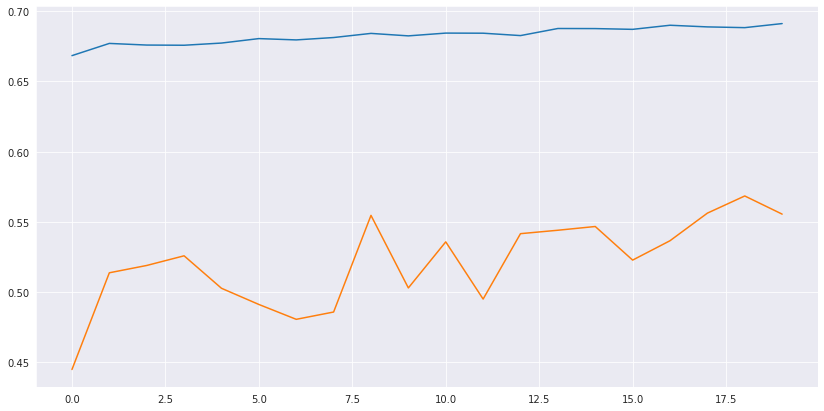

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
#modelL.save_weights('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-modelL.h5')

#### Распознавание

In [ ]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3))     # Создаем модель linearSegmentationNet
modelL.load_weights('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-modelL.h5')

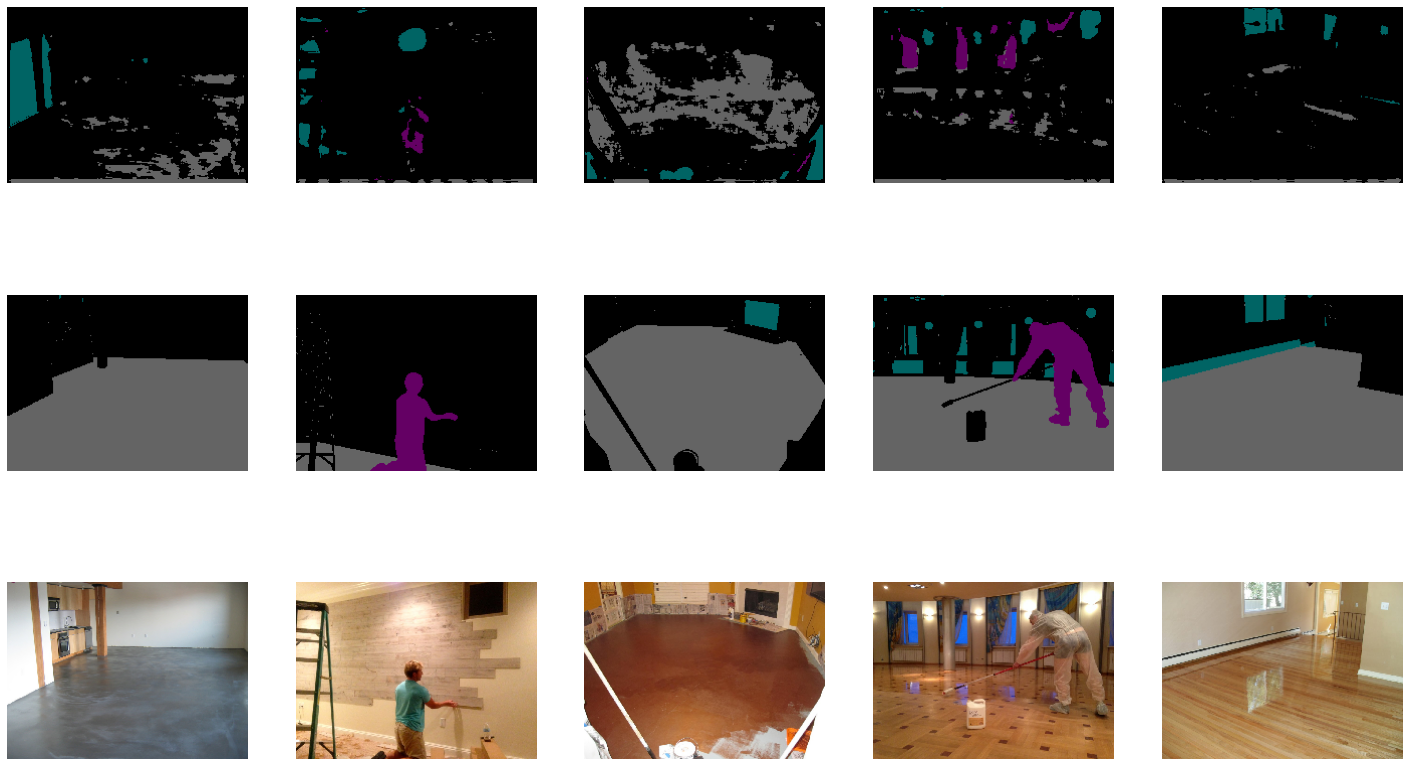

In [ ]:
processImage(modelL, 5, num_classes)

### U-net

**Пробовал разные активационные функции и размеры batch_size**

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(num_classes = 3, input_shape= (88, 120, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                        # Добавляем слой MaxPooling2D

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                        # Добавляем слой MaxPooling2D

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                        # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = concatenate([x, block_1_out])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet

In [ ]:
modelUnet.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 64) 1792        input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, 176, 240, 64) 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_69 (Activation)      (None, 176, 240, 64) 0           batch_normalization_69[0][0]     
______________________________________________________________________________________

In [ ]:
history = modelUnet.fit(xTrain, yTrain, epochs=30, batch_size=32, validation_data = (xVal, yVal)) # Обучаем модель 

Epoch 1/30
29/29 [==============================] - 15s 525ms/step - loss: 0.6528 - dice_coef: 0.6698 - val_loss: 6.5077 - val_dice_coef: 0.4849
Epoch 2/30
29/29 [==============================] - 15s 509ms/step - loss: 0.4893 - dice_coef: 0.7474 - val_loss: 6.8839 - val_dice_coef: 0.4421
Epoch 3/30
29/29 [==============================] - 15s 509ms/step - loss: 0.4543 - dice_coef: 0.7675 - val_loss: 4.2450 - val_dice_coef: 0.2836
Epoch 4/30
29/29 [==============================] - 15s 509ms/step - loss: 0.4181 - dice_coef: 0.7853 - val_loss: 2.2512 - val_dice_coef: 0.4384
Epoch 5/30
29/29 [==============================] - 15s 509ms/step - loss: 0.3929 - dice_coef: 0.8013 - val_loss: 1.4771 - val_dice_coef: 0.5639
Epoch 6/30
29/29 [==============================] - 15s 509ms/step - loss: 0.3848 - dice_coef: 0.8013 - val_loss: 0.8981 - val_dice_coef: 0.6033
Epoch 7/30
29/29 [==============================] - 15s 508ms/step - loss: 0.3716 - dice_coef: 0.8056 - val_loss: 4.2635 - val_dic

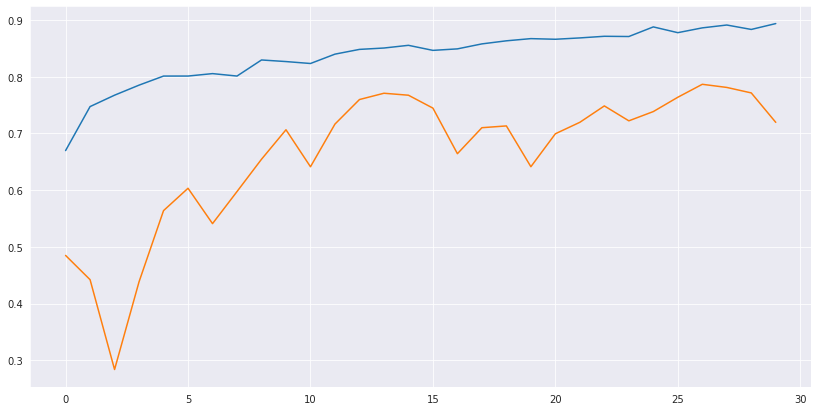

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
#modelUnet.save_weights('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-modelUnet.h5')

#### Распознавание

In [ ]:
modelUnet = unet(num_classes, (img_width, img_height, 3)) # Создаем модель unet
modelUnet.load_weights('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-modelUnet.h5')

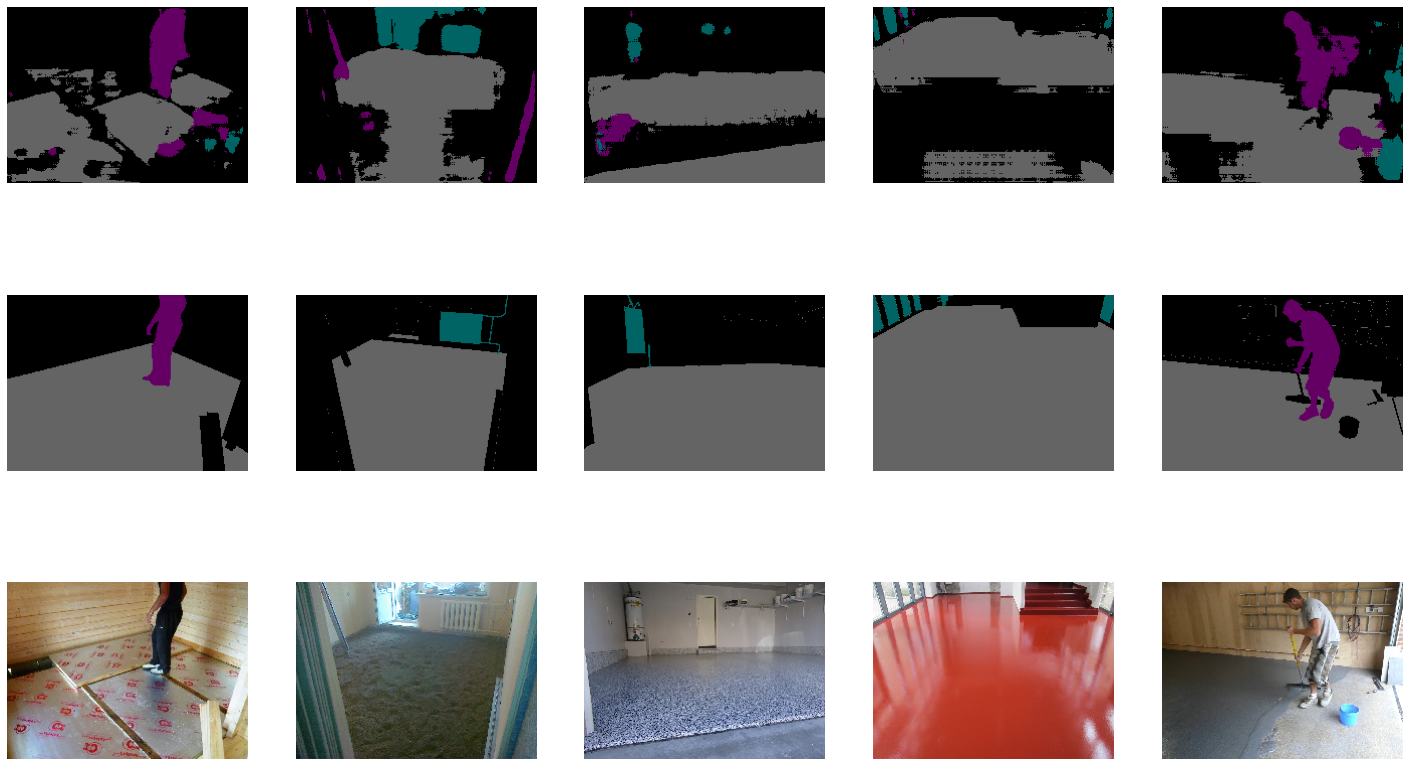

In [ ]:
processImage(modelUnet, 5, num_classes)

**На этом задание Light закончено. Краткий вывод таков: что не меняй, а U-сеть сильнее**

**Функция активации relu давала лучшие результаты**

**Показалось, что лучше обучается (по точности)  при уменьшении batch_size**

**Модель типа U-net доученная до 89/77% на обучающей/проверочной выборке стала давать смотрибельную сегментацию**




##Pro задание. 

**Вариант 1**

Напишите PSPNet для сегментации на базе стройки, добейтесь максимально возможной точности.



In [ ]:
# Загружаем подготовленные выборки (массивы) с гугл-диска

xTrain = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-xTrain.npy')
xVal = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-xVal.npy')
yTrain = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-yTrain.npy')
yVal = np.load('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-yVal.npy')

print(xTrain.shape)
print(xVal.shape)
print(yTrain.shape)
print(yVal.shape)

(900, 176, 240, 3)
(50, 176, 240, 3)
(900, 176, 240, 6)
(50, 176, 240, 6)


### Pyramid Scene Parsing Network (PSPNet)

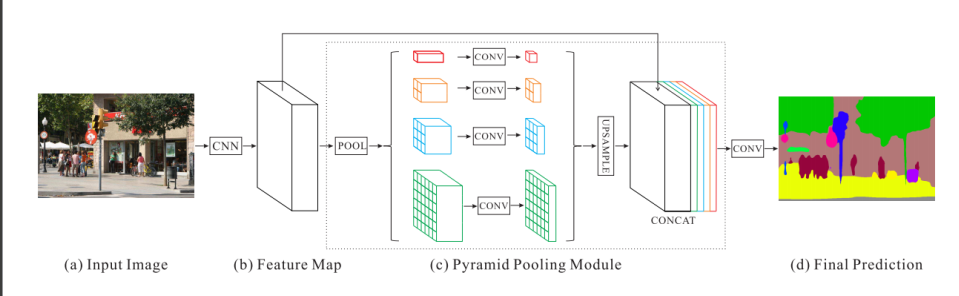

***Импорт библиотек, подключение гугл-диска и определение функций метрики и визуализации находятся в разделе Light***

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def pspnet(num_classes = 6, input_shape= (176, 240, 3)):
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Feature Map
    x = Conv2D(64, (3, 3), padding='same', name='feature_map_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                    # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='feature_map_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                    # Добавляем слой Activation
 
    x = Conv2D(256, (3, 3), padding='same', name='feature_map_conv3')(x)         # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    feature_map_out = Activation('relu', name='feature_map_out')(x)              # Добавляем слой Activation 
 

    # Pyramyd Pooling Module
    # red
    #red = GlobalAveragePooling2D(name='red_pool')(feature_map_out)
    #red = Reshape((1,1,256))(red)
    red = AveragePooling2D(pool_size=(1,1),name='red_pool')(feature_map_out)
    red = Conv2D(filters=64,kernel_size=(1,1),name='red_conv')(red)
    #red = UpSampling2D(size=256,interpolation='bilinear',name='red_upsampling')(red)
    red = UpSampling2D(size=1,interpolation='bilinear',name='red_upsampling')(red)

    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(feature_map_out)
    yellow = Conv2D(filters=64,kernel_size=(1,1),name='yellow_conv')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)

    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(feature_map_out)
    blue = Conv2D(filters=64,kernel_size=(1,1),name='blue_conv')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)

    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(feature_map_out)
    green = Conv2D(filters=64,kernel_size=(1,1),name='green_conv')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)

    # feature_map + red + yellow + blue + green
    pooling_module_out = concatenate([feature_map_out,red,yellow,blue,green])


    # Final Prediction
    x = Conv2D(64, (3, 3), padding='same')(pooling_module_out)                   # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                                  # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                                    # Добавляем слой Activation

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

In [ ]:
modelPSPnet = pspnet(num_classes, (img_width, img_height, 3)) # Создаем модель

In [ ]:
modelPSPnet.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
feature_map_conv1 (Conv2D)      (None, 176, 240, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 176, 240, 64) 256         feature_map_conv1[0][0]          
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 176, 240, 64) 0           batch_normalization_4[0][0]      
_______________________________________________________________________________________

In [ ]:
history = modelPSPnet.fit(xTrain, yTrain, epochs=200, batch_size=4, validation_data = (xVal, yVal)) # Обучаем модель 

Epoch 1/200
225/225 [==============================] - 23s 100ms/step - loss: 0.7069 - dice_coef: 0.6245 - val_loss: 1.3593 - val_dice_coef: 0.4824
Epoch 2/200
225/225 [==============================] - 22s 99ms/step - loss: 0.6333 - dice_coef: 0.6582 - val_loss: 1.3589 - val_dice_coef: 0.3651
Epoch 3/200
225/225 [==============================] - 22s 99ms/step - loss: 0.6111 - dice_coef: 0.6697 - val_loss: 1.4170 - val_dice_coef: 0.4194
Epoch 4/200
225/225 [==============================] - 22s 99ms/step - loss: 0.5955 - dice_coef: 0.6755 - val_loss: 0.9781 - val_dice_coef: 0.4817
Epoch 5/200
225/225 [==============================] - 22s 99ms/step - loss: 0.5913 - dice_coef: 0.6789 - val_loss: 1.0035 - val_dice_coef: 0.5067
Epoch 6/200
225/225 [==============================] - 22s 99ms/step - loss: 0.5733 - dice_coef: 0.6868 - val_loss: 0.9001 - val_dice_coef: 0.5798
Epoch 7/200
225/225 [==============================] - 22s 99ms/step - loss: 0.5591 - dice_coef: 0.6928 - val_loss: 0

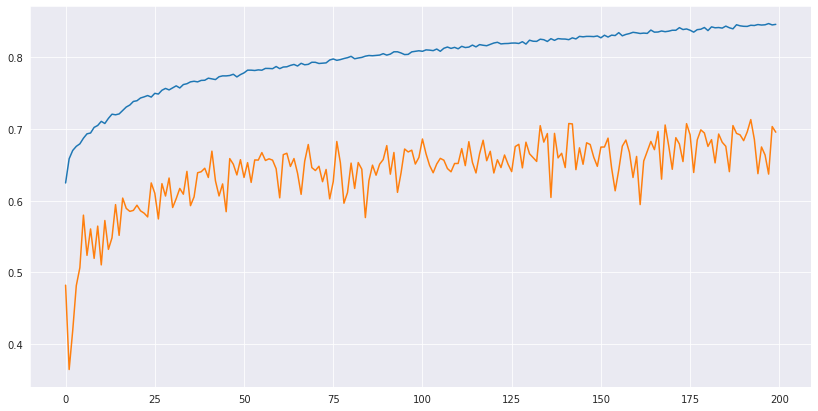

In [ ]:
# Отобразим график обучения модели
plt.figure(figsize=(14,7))
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [ ]:
modelPSPnet.save_weights('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-modelPSPnet.h5')

#### Распознавание

In [ ]:
modelPSPnet = pspnet(num_classes, (img_width, img_height, 3)) # Создаем модель и загружаем веса
modelPSPnet.load_weights('/content/drive/My Drive/my_sample_data/Д.З.25/Сегментация_стройки-modelPSPnet.h5')

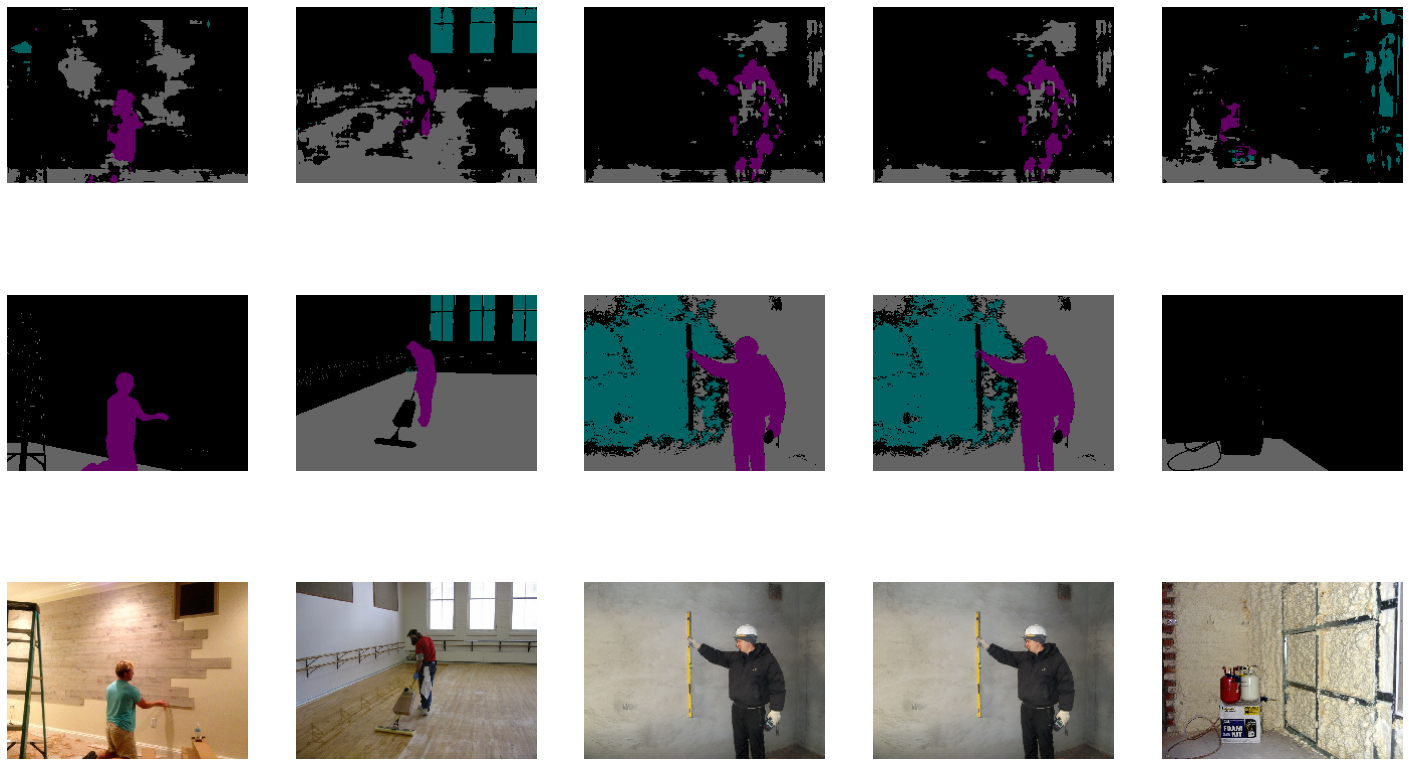

In [ ]:
processImage(modelPSPnet, 5, num_classes)

#### Получившаяся модель PSPnet еще имеет потенциал для обучения и для подбора гиперпараметров.  
#### Тем не менее некоторые классы она уже разпознает.

####  Ниже код чтобы посмотреть состояние среды выполнения колаба

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Nov 16 09:03:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    31W / 250W |   7721MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!
